In [1]:
from collector.collector_factory import CollectorFactory
from writer.writer_factory import WriterFactory
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F

c:\Users\Susana\anaconda3\envs\aa1\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1. Collect and write data

In [2]:
collector = CollectorFactory.initialize_collector('APIncbi')
writer = WriterFactory.initialize_writer('FileWriter')
writer.set_path('./data')
list = []
n = 10000
for seq_object in collector.collect(n):
    writer.write(seq_object[0], str(seq_object[1]))
    list.append(seq_object[1])

10000 results found.


In [4]:
unique_seq = set(list)
print(len(unique_seq))

3563


### 2.1 Get data

In [10]:
aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
amino_dict = {amino: idx for idx, amino in enumerate(aminoacids)}

def one_hot_encode(secuencia, max_length):
    encoding = np.zeros((max_length, len(aminoacids)))
    
    for i, amino in enumerate(secuencia):
        if amino not in amino_dict:
            print("Unrecognized amino acid:", amino)
        else:
            encoding[i, amino_dict[amino]] = 1
    return encoding.flatten()

data = []

for seq in unique_seq:
    data.append({'sequence': str(seq)})

max_length = max(len(record['sequence']) for record in data)

df = pd.DataFrame(data)

display(df.head())

,sequence
0,IIGGTECKPHSRPYMAYLEIVTSNGPSKFCGGFLIRRNFVLTAAHC...
1,GGTLSLTCTVSGGSMTSSYWNWIRQTPTRGLEWIGYIYYAGTTNYN...
2,MIEVEAPITVCGDIHGQFFDLMKLFEVGGSPANTRYLFLGDYVDRG...
3,MTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSIS...
4,MKSCAVSLTTAAVAFGDEAKKMAEGKASRESEEESVSLTVEEREAL...


### 2.1. Encoding the data with a variation of bag of words

In [11]:
def alpha(i, n):
    return (n - i) * 1 / n

aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
dict_amino = {amino: idx for idx, amino in enumerate(aminoacids)}


def get_vector_byMaxN(seq, alpha,n):
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

def get_vector_bySeqN(seq, alpha):
    n = len(seq)
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

In [12]:
n = max(len(record['sequence']) for record in data)
v = get_vector_byMaxN(df['sequence'][0], alpha, n)
df['vectorMaxN'] = df['sequence'].apply(lambda x: get_vector_byMaxN(x, alpha, n))
df['vectprSeqN'] = df['sequence'].apply(lambda x: get_vector_bySeqN(x, alpha))

In [13]:
display(df.head())

,sequence,vectorMaxN,vectprSeqN
0,IIGGTECKPHSRPYMAYLEIVTSNGPSKFCGGFLIRRNFVLTAAHC...,"[15.5983206404999, 6.861745752782659, 7.777777...","[6.898230088495574, 3.8672566371681416, 2.9646..."
1,GGTLSLTCTVSGGSMTSSYWNWIRQTPTRGLEWIGYIYYAGTTNYN...,"[6.906463581331771, 1.9830111306385472, 1.9744...","[2.523364485981308, 1.1869158878504673, 0.7757..."
2,MIEVEAPITVCGDIHGQFFDLMKLFEVGGSPANTRYLFLGDYVDRG...,"[21.97930091778949, 12.548330404217925, 19.265...","[10.25121951219512, 7.3585365853658535, 10.831..."
3,MTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSIS...,"[24.79105643429018, 9.696153095098612, 30.5561...","[13.020964360587, 6.7379454926624724, 16.49895..."
4,MKSCAVSLTTAAVAFGDEAKKMAEGKASRESEEESVSLTVEEREAL...,"[47.741652021089635, 13.187072837336457, 21.91...","[28.857404021937857, 6.3893967093235835, 12.84..."


### 3. Unsupervised Learning

### 3.1. DBSCAN

In [57]:
X = np.array(df['vectorMaxN'].tolist())

X_scaled = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.85, min_samples=30)
clusters = dbscan.fit_predict(X_scaled)

df['cluster'] = clusters

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Clusters:", num_clusters)

Clusters: 4


In [58]:
print(df['cluster'].value_counts())

cluster
-1    2233
 0    1133
 3      77
 2      70
 1      50
Name: count, dtype: int64


In [59]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

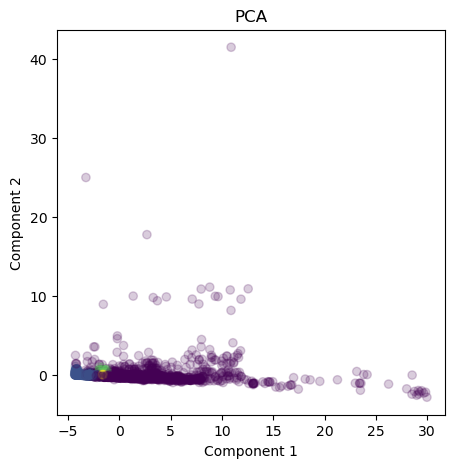

In [60]:
plt.figure(figsize=(5, 5))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters, cmap='viridis',  alpha=0.2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')
plt.show()

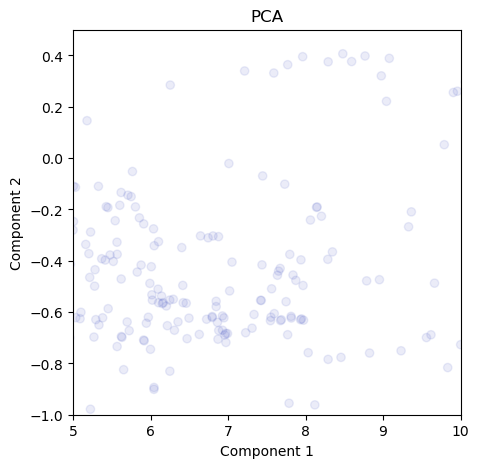

In [61]:


plt.figure(figsize=(5, 5))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters, cmap='coolwarm',  alpha=0.1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')
plt.xlim(5, 10)
plt.ylim(-1, 0.5)
plt.show()


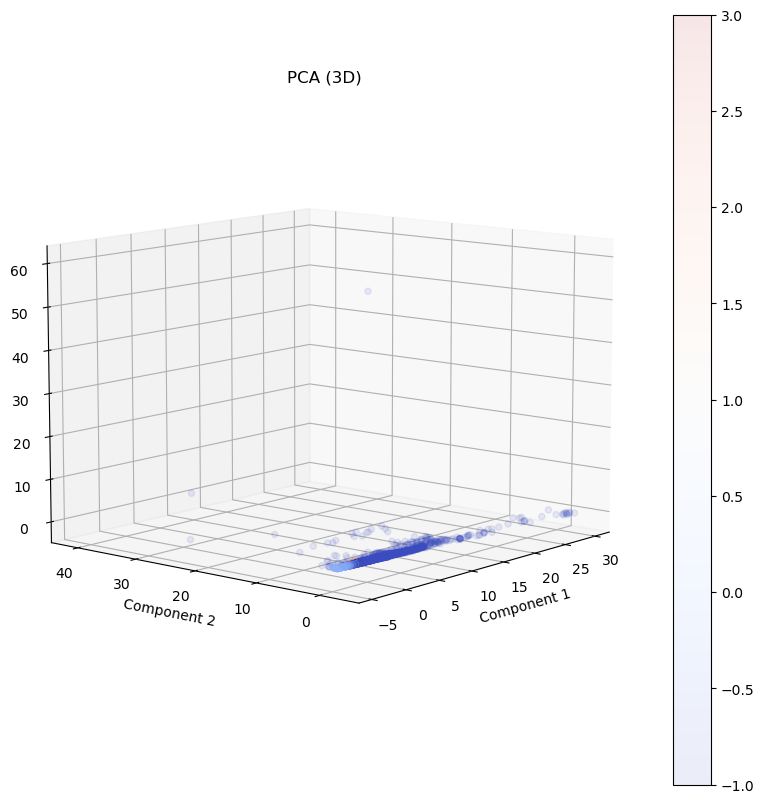

In [62]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(principalComponents3d[:, 0], principalComponents3d[:, 1], principalComponents3d[:, 2], c=clusters, cmap='coolwarm',  alpha=0.1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('PCA (3D)')

ax.view_init(10, 220)

fig.colorbar(scatter)

plt.show()

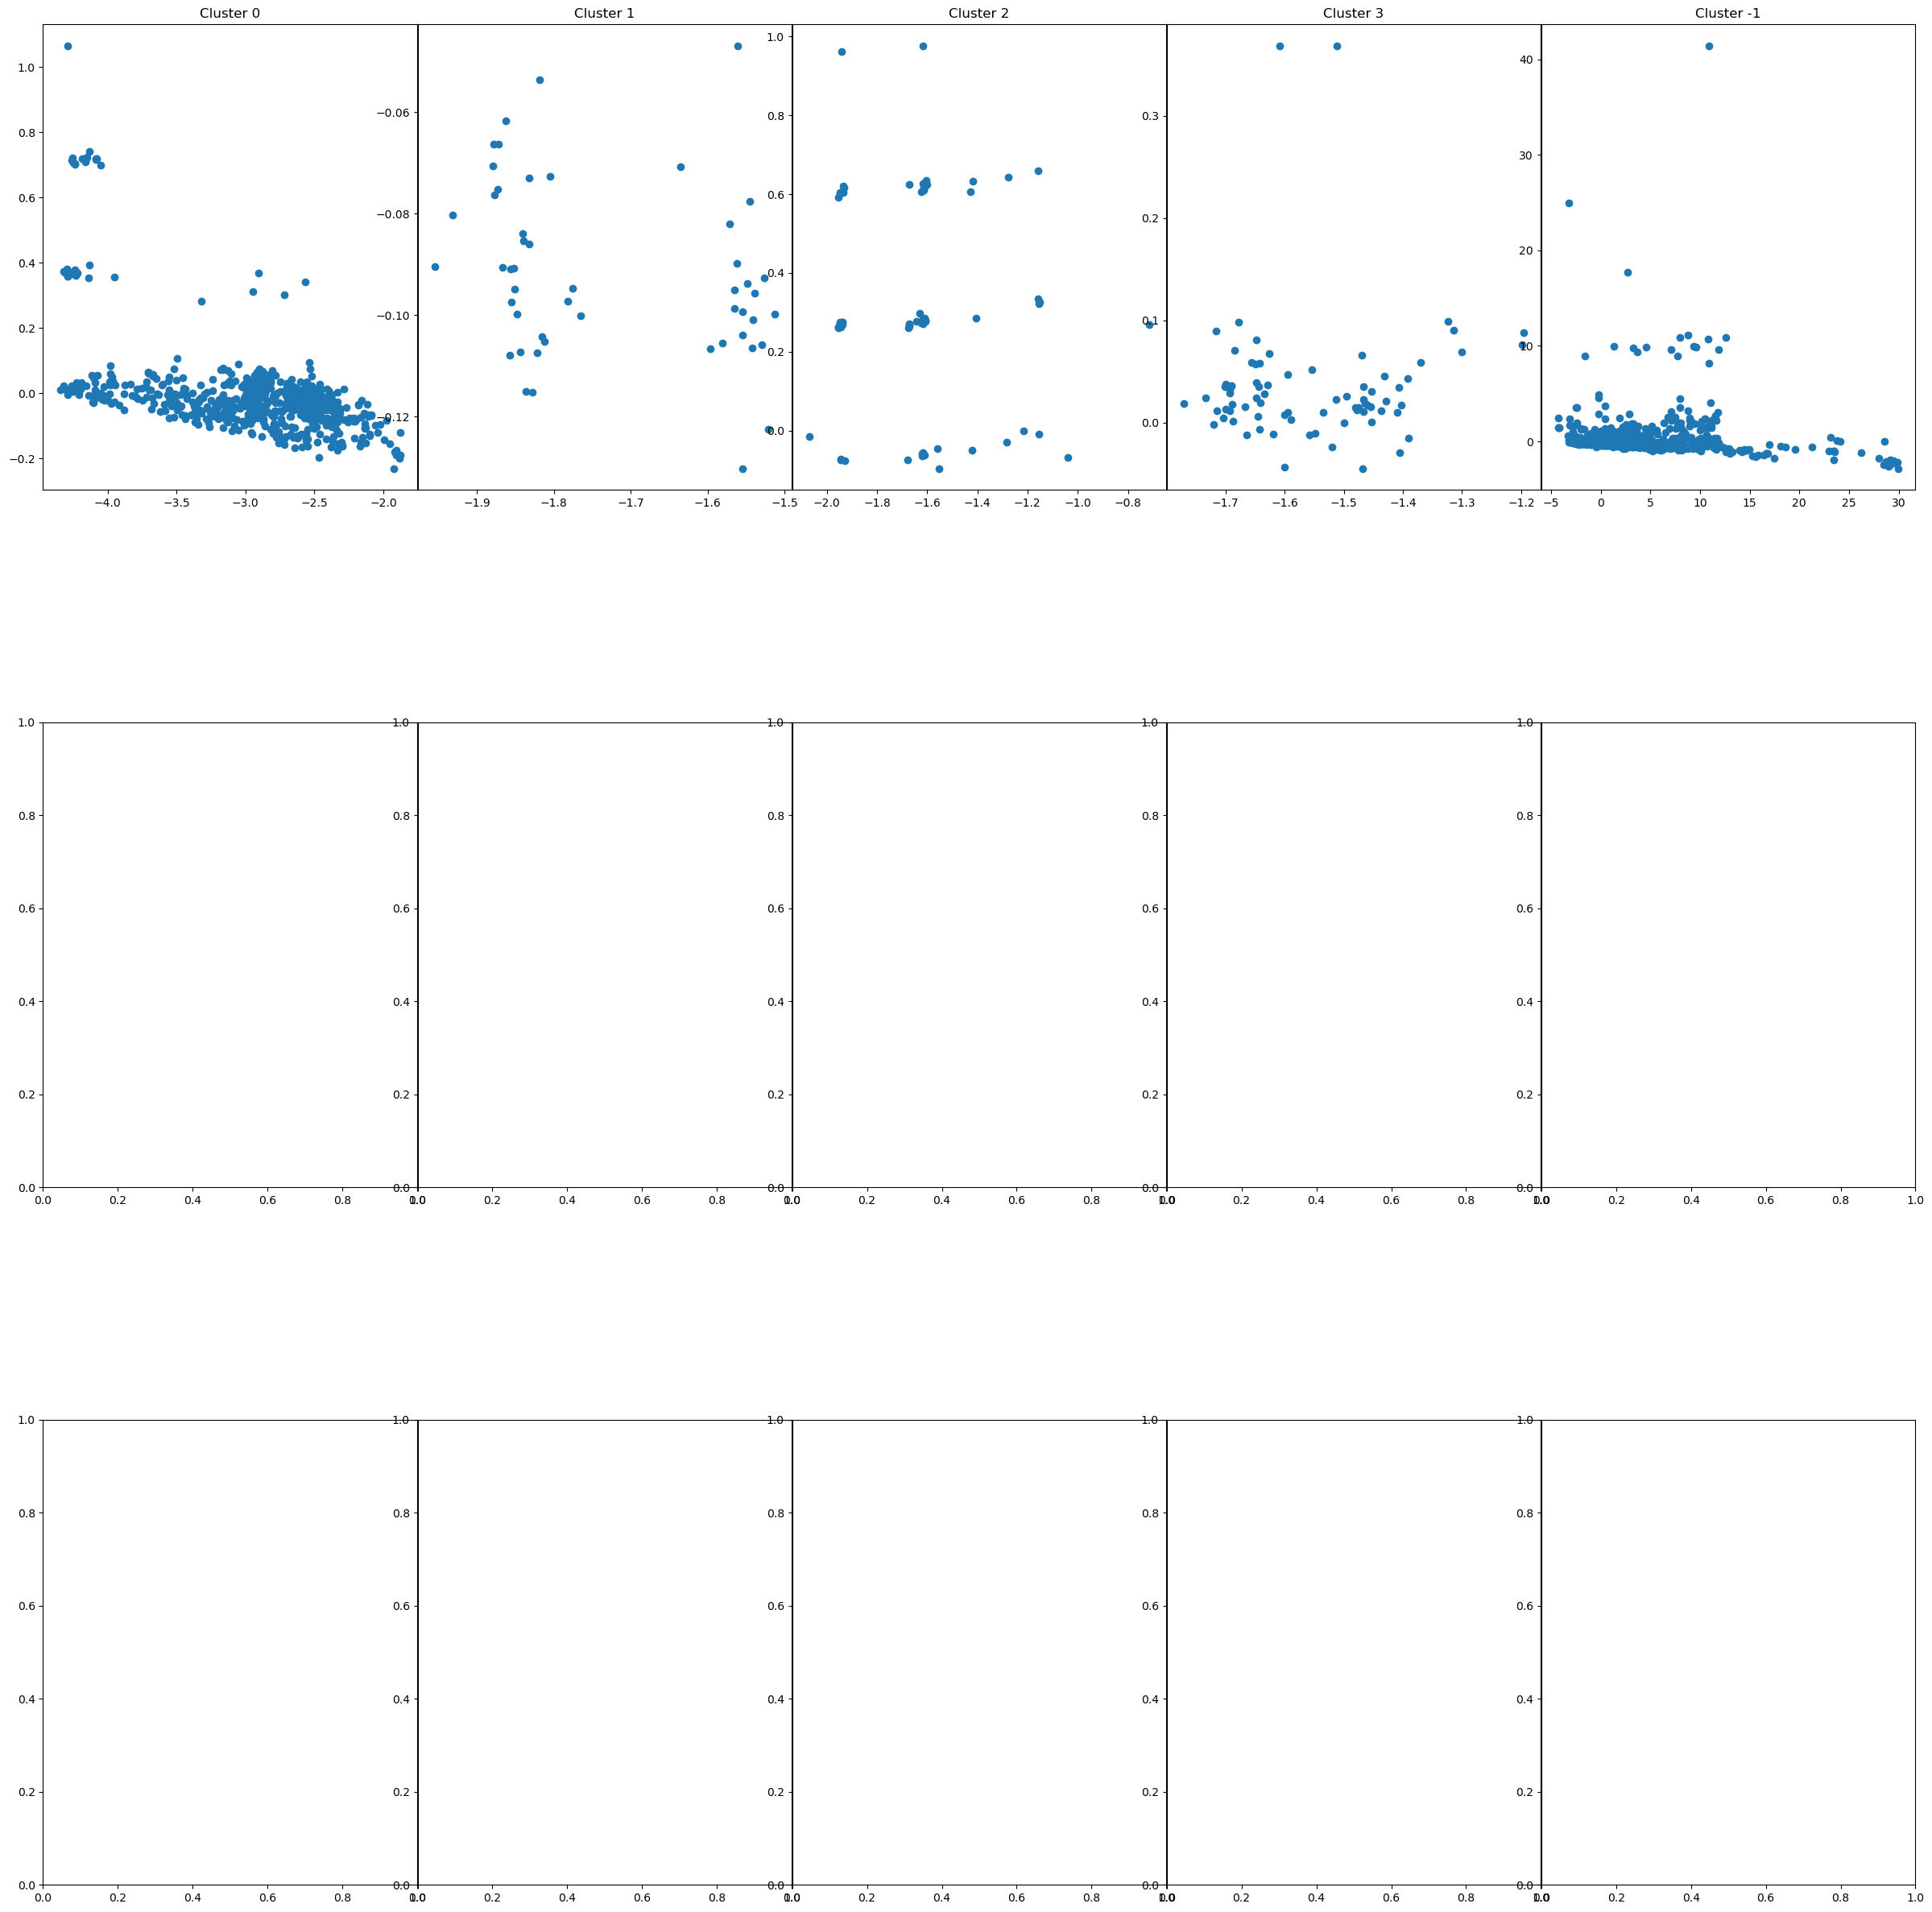

In [63]:
#hacer una grafica por cada cluster en 4 filas 5 columnas
fig, axs = plt.subplots(3, 5, figsize=(30, 30))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1])
    axs[i].set_title(f'Cluster {i}')
    
cluster = df[df['cluster'] == -1]
axs[i+1].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1])
axs[i+1].set_title(f'Cluster -1')
plt.show()

In [13]:
#imprimir dos secuencias del mismo cluster 
cluster = 17
df_cluster = df[df['cluster'] == cluster]
display(df_cluster.head()['sequence'])
display(df_cluster.tail()['sequence'])


Series([], Name: sequence, dtype: object)

Series([], Name: sequence, dtype: object)

### 3.2. K-means

In [43]:
X = np.array(df['vector'].tolist())

inertia = []
k_values = range(12, 400, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


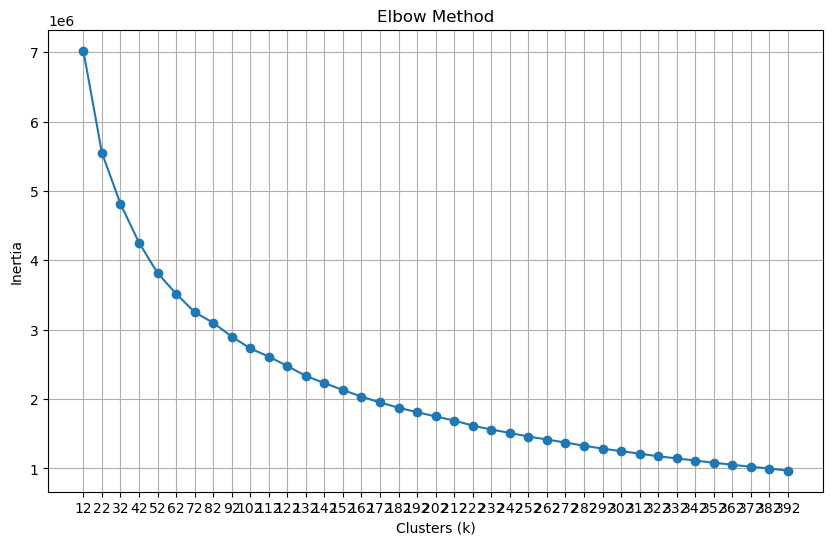

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

### 4. Analysis of results

### 4.1. Cosine similarity

In [64]:
average_similarity = {}

for cluster_id in set(clusters):
    if cluster_id == -1:
        continue

    cluster_docs_indices = df[df['cluster'] == cluster_id].index.tolist()
    
    cluster_size = len(cluster_docs_indices)
    similarity_matrix = np.zeros((cluster_size, cluster_size))
    
    for i in range(cluster_size):
        for j in range(cluster_size):
            vec_i = torch.tensor(X_scaled[cluster_docs_indices[i]], dtype=torch.float32).unsqueeze(0)
            vec_j = torch.tensor(X_scaled[cluster_docs_indices[j]], dtype=torch.float32).unsqueeze(0)

            similarity_matrix[i][j] = F.cosine_similarity(vec_i, vec_j).item()

    avg_similarity = similarity_matrix[np.triu_indices(cluster_size, k=1)].mean()
    average_similarity[cluster_id] = avg_similarity

for cluster_id, avg_sim in average_similarity.items():
    print(f"Cluster {cluster_id}: Average Cosine Similarity = {avg_sim}")

Cluster 0: Average Cosine Similarity = 0.9399567146530573
Cluster 1: Average Cosine Similarity = 0.960252747389735
Cluster 2: Average Cosine Similarity = 0.9184996964274973
Cluster 3: Average Cosine Similarity = 0.8914135707541027


In [45]:
#imprimir el cluster 8
cluster = 10
df_cluster = df[df['cluster'] == cluster]
display(df_cluster.head()['sequence'])
display(df_cluster.tail()['sequence'])

8081    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8082    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8083    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8084    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8085    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
Name: sequence, dtype: object

8230    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8231    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8232    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8233    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
8234    STSQVRQNYHQDSEAAINRQINLELYASYVYLSMSYYFDRDDVALK...
Name: sequence, dtype: object

### cosas que falran
1. dejar bonito el notebook
2. api
3. readme: (trabajo futuro)